In [1]:
import torch.nn as nn
import torch

In [2]:
torch.cuda.empty_cache() 

In [3]:
torch.cuda.is_available()

True

%%bash
git commit -a -m "studying basic stats further  "

https://www.rileynwong.com/blog/2019/2/25/generating-music-with-an-lstm-neural-network

In [4]:
from IPython.core.debugger import Pdb

# basic library loading

In [5]:
from plotnine import *

import pandas as pd

import numpy as np

# data preparation

In [6]:
max_sequence_length = 100

In [7]:
def split_list(l, n):
    """
    リストをサブリストに分割する
    :param l: リスト
    :param n: サブリストの要素数
    :return: 
    """
    for idx in range(0, len(l), n):
        yield l[idx:idx + n]

In [8]:
import glob

In [9]:
import score2df

In [10]:
from importlib import reload

In [ ]:
reload(score2df)

## 差分バージョン

In [11]:
is_discrete = True

In [12]:
run_mode = 'major'
#run_mode = 'minor'
#run_mode = None

In [13]:
from music21 import converter, instrument, note, chord

In [14]:
id = str(is_discrete)

In [15]:
pkl_path = 'saved/seq_df_scores_{}.pkl'.format(id)

In [16]:
is_use_preprocessed_df = True

In [17]:
df_scores = pd.DataFrame()
if is_use_preprocessed_df:
    df_scores = pd.read_pickle(pkl_path)
else:
    for file in glob.glob("chorales/midi/*.mid"):
        print(file)
        df_score = score2df.score2dataframe(file)
        df_score = score2df.add_sequential_diffs(df_score)
        df_score = df_score.assign(file = file)
        df_scores = df_scores.append(df_score , ignore_index = True )
        
    df_scores.to_pickle(pkl_path)

In [18]:
if run_mode == 'major':
    df_scores = df_scores.query("mode == 'major'")

if run_mode == 'minor':
    df_scores = df_scores.query("mode == 'minor'")

## dtを0か0.25だけにする(optional)

In [22]:
df_scores = df_scores.assign(dt = np.where(df_scores.dt > 0.001 , 0.25 , df_scores.dt))

In [23]:
df_scores = df_scores.assign(dt = np.where(df_scores.dt > 2.0 , np.nan , df_scores.dt))

In [24]:
df_scores.dropna(subset = ['dcent', 'dt'] , inplace=True)

## tmp

In [ ]:
df_scores.head()

## have a look at the data

In [ ]:
df_scores.head()

In [ ]:
df_scores.describe()

In [ ]:
ggplot(df_scores , aes(x = 'dt' , y = 'dcent' , color = 'n')) + geom_point() + theme_minimal()

In [ ]:
ggplot(df_scores.query('dt != 0') , aes(fill = 'n' , x = 'dcent / 100')) + geom_histogram() + theme_minimal()

In [ ]:
len(set(df_scores.query('abs(dcent/100)>20 & n != 0')['file']))

In [ ]:
from IPython.display import Image

Image(filename=converter.parse('chorales/midi/000101b_.mid').write('lily.png'))

In [ ]:
ggplot(df_scores.query('dt == 0') , aes(fill = 'n' , x = 'dcent / 100')) + geom_histogram() + theme_minimal()

In [ ]:
ggplot(df_scores.query('dt == 0') , aes(color = 'n' , x = 'dcent')) + geom_histogram() + facet_wrap('~n') + theme_void()

## preprocess 2

In [29]:
if is_discrete:
    dtype = str
else:
    dtype = np.float64

In [30]:
notes_list = []
dt_list = []
for f in set(df_scores.file):
    df_file = df_scores[df_scores.file == f]

    run_notes = df_file.dcent.astype(dtype)
    run_dts = df_file.dt.astype(dtype)
    for n in split_list(run_notes , max_sequence_length):
        if len(n) > 10:
            notes_list.append(n)
    for n in split_list(run_dts , max_sequence_length):
        if len(n) > 10:
            dt_list.append(n)
        

In [31]:
len(notes_list)

1707

#### linear regresssion


https://www.statsmodels.org/dev/example_formulas.html

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
mod = smf.ols(formula = 'dcent ~ dt' , data = df_scores)

In [ ]:
res = mod.fit()

print(res.summary())

https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

## pre-pack procedures

In [32]:
from music21 import converter, instrument, note, chord

### with label encoding (for discrete version)
https://towardsdatascience.com/encoding-categorical-features-21a2651a065c
に概ね準拠仕様と思ったが・・・

- そもそもlabelencoder -> onehot  は今後必要ないよとwarning が出る
- onehot の挙動が読みにくい

のでlabelencodingしたあと直にnp.arrayをmanual onehote化したほうがいいのではないか？？

In [33]:
raw_y1, raw_X1 , le1 = score2df.yx_encoder(notes_list)

In [34]:
raw_y2, raw_X2 , le2 = score2df.yx_encoder(dt_list)

In [35]:
raw_X = [torch.cat((raw_X1[i] , raw_X2[i]) , 1) for i in range(len(raw_X1))]

## pad and pack

In [36]:
packed_X = torch.nn.utils.rnn.pack_sequence(raw_X , enforce_sorted=False)

ppd_X = torch.nn.utils.rnn.pad_packed_sequence(packed_X)

In [37]:
packed_y1 = torch.nn.utils.rnn.pack_sequence(raw_y1 , enforce_sorted=False)

ppd_y1 = torch.nn.utils.rnn.pad_packed_sequence(packed_y1)

In [38]:

packed_y2 = torch.nn.utils.rnn.pack_sequence(raw_y2 , enforce_sorted=False)

ppd_y2 = torch.nn.utils.rnn.pad_packed_sequence(packed_y2)

### reference

- [OneHotEncoderだけでいける。LabelEncoderをかます必要なし]と当初思っていたがむしろ逆



https://stackoverflow.com/questions/30869382/encoding-string-to-numbers-so-as-to-use-it-in-scikit-learn

Another possible good reference:
https://stackoverflow.com/questions/30869382/encoding-string-to-numbers-so-as-to-use-it-in-scikit-learn


## mask

In [ ]:
mask = torch.Tensor([len(x) - 1 for x in notes_list])
                     

or

In [39]:
mask = ppd_X[1]

# LTSM

参考文献のpreprocessはあまり納得いかないので・・

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

をみつつやってみるか

## 参考文献に似せたモデル
https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5
に似せたモデル


softmaxを二重にかけないように注意

In [40]:
class my_model(nn.Module):

    def __init__(self, input_size1 , input_size2, hidden_size, num_layers , dropout):
        #super(my_model, self).__init__()
        
        super().__init__()

        self.relu = nn.ReLU()
        
        input_size = input_size1 + input_size2
        


        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers , dropout=dropout)

        self.linear1 = nn.Linear(hidden_size, input_size1) #output dimension has to be identical with the input dimension
        
        self.linear2 = nn.Linear(hidden_size, input_size2) #output dimension has to be identical with the input dimension
 
        self.linear1b = nn.Linear(input_size1, input_size1) #output dimension has to be identical with the input dimension
        
        self.linear2b = nn.Linear(input_size2, input_size2) #output dimension has to be identical with the input dimension
  
     


    def forward(self, input):
        #self.h0 = torch.randn(self.num_layers , sequence_num , self.hidden_size)
        #self.c0 = torch.randn(self.num_layers , sequence_num, self.hidden_size)
        y, (hn, cn) = self.rnn(input)#, (self.h0, self.c0))
        y1 = self.linear1(y)
        y1 = self.relu(y1)
        y1 = self.linear1b(y1)
        y2 = self.linear2(y)
        y2 = self.relu(y2)
        y2 = self.linear2b(y2)
       
        return y1,y2
    

In [41]:
input_size1 = raw_X1[0].shape[1]
input_size2 = raw_X2[0].shape[1]
hidden_size = 512 
num_layers = 2
dropout = 0.1

In [42]:
model = my_model(input_size1 , input_size2 , hidden_size , num_layers , dropout)

## dimensionality check

In [ ]:
y_tmp1 ,y_tmp2 = model.forward(ppd_X[0][:, 0:10])

In [ ]:
y_tmp1.shape

In [ ]:
y_tmp2.shape

##    連続バージョン

https://stackoverflow.com/questions/49040180/change-tanh-activation-in-lstm-to-relu

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, nlayers, dropout):
        """"Constructor of the class"""
        super(LSTMCell, self).__init__()

        self.nlayers = nlayers
        self.dropout = nn.Dropout(p=dropout)

        ih, hh = [], []
        for i in range(nlayers):
            ih.append(nn.Linear(input_size, 4 * hidden_size))
            hh.append(nn.Linear(hidden_size, 4 * hidden_size))
        self.w_ih = nn.ModuleList(ih)
        self.w_hh = nn.ModuleList(hh)

    def forward(self, input, hidden):
        """"Defines the forward computation of the LSTMCell"""
        hy, cy = [], []
        for i in range(self.nlayers):
            hx, cx = hidden[0][i], hidden[1][i]
            gates = self.w_ih[i](input) + self.w_hh[i](hx)
            i_gate, f_gate, c_gate, o_gate = gates.chunk(4, 1)

            i_gate = F.sigmoid(i_gate)
            f_gate = F.sigmoid(f_gate)
            c_gate = F.tanh(c_gate)
            o_gate = F.sigmoid(o_gate)

            ncx = (f_gate * cx) + (i_gate * c_gate)
            nhx = o_gate * F.tanh(ncx)
            cy.append(ncx)
            hy.append(nhx)
            input = self.dropout(nhx)

        hy, cy = torch.stack(hy, 0), torch.stack(cy, 0)
        return hy, cy

# criterion (cross entropy lossはlog softmaxを含んでいるので二重に作用させないよう注意が必要）

cross entropy for one-hot representation
https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/4

one-hotのままでなくて、Rでいうところのfactorに戻したほうがよさそう（？）


In [43]:
criterion = nn.CrossEntropyLoss(reduction='sum')


input has to be a Tensor of size either (minibatch, C)(minibatch,C) or (minibatch, C, d_1, d_2, ..., d_K)

# GPU tool

In [44]:
is_use_gpu = True


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() and is_use_gpu else "cpu")

In [46]:
cpu = torch.device("cpu")

# optimizer

In [47]:
import torch.optim as optim# optimizer

In [48]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [49]:
optimizer = optim.Adam(model.parameters())

# optimization

In [50]:
from IPython.display import display

In [51]:
sample_size = ppd_X[0].shape[1]

In [52]:
print("sample size : {}".format(sample_size))

sample size : 1707


In [53]:
batch_size = 20

In [54]:
batch_indices = range( 0 ,sample_size ,  batch_size)

## n epochs

In [55]:
losses1 = []
losses2 = []

In [56]:
prob_when_random1 = 1 /input_size1

In [57]:
prob_when_random2 = 1 / input_size2

In [ ]:
reload(score2df)

In [58]:
#model_path = 'saved/model20191124_{}'.format(id)

#model_path = 'saved/model20191125_{}'.format(id)

# model_path = 'saved/model20191207_{}'.format(id)


#model_path = 'saved/model20191208b_{}'.format(id)



#model_path = 'saved/model20191221_{}'.format(id)
#model_path = 'saved/model20191226_{}'.format(id)


model_path = 'saved/model20191230_{}_{}'.format(id,str(run_mode))

In [59]:
n_epochs = 200

In [60]:
model.to(device)
model.train()
for k in range(n_epochs):
    batch_loss1 = 0
    batch_loss2 = 0

    shuffled_idx = torch.randperm(sample_size)
    for i in batch_indices:
        #display(".")
        batch_samples = shuffled_idx[i:min(i + batch_size , sample_size) ]

        loss1, loss2 = score2df.batch_loss_2vars(ppd_y1, ppd_y2 , ppd_X , mask , batch_samples , device , model , criterion)
        batch_loss1 += loss1.item()
        batch_loss2 += loss2.item()
        loss = loss1 + loss2

        
        loss.backward()

        optimizer.step()
    batch_loss1 /= torch.sum(mask).item()
    losses1.append(batch_loss1)
    mean_correct_prob1 = np.exp(-batch_loss1)
    batch_loss2 /= torch.sum(mask).item()
    losses2.append(batch_loss2)
    mean_correct_prob2 = np.exp(-batch_loss2)    
    if k % 10 == 0:
        torch.save(model.state_dict() , model_path)
        display("epoch : {}".format(k))
        display("  [dcent] loss : {}   correct prob : {} correct / random : {}".format(batch_loss1 ,
                                                                        mean_correct_prob1 ,
                                                                        mean_correct_prob1 / prob_when_random1))
        
        display("  [dt] loss : {}   correct prob : {} correct / random : {}".format(batch_loss2 ,
                                                                        mean_correct_prob2 ,
                                                                        mean_correct_prob2 / prob_when_random2))

model.cpu()
torch.cuda.empty_cache() 

'epoch : 0'

'  [dcent] loss : 3.549341510473613   correct prob : 0.028743560757591487 correct / random : 3.0755610010622894'

'  [dt] loss : 0.6746172456994607   correct prob : 0.5093513397178682 correct / random : 1.0187026794357363'

'epoch : 10'

'  [dcent] loss : 2.849095721818153   correct prob : 0.05789665188948072 correct / random : 6.194941752174437'

'  [dt] loss : 0.4297621103235847   correct prob : 0.6506638625294673 correct / random : 1.3013277250589346'

'epoch : 20'

'  [dcent] loss : 2.0587922432761596   correct prob : 0.1276079962784187 correct / random : 13.654055601790802'

'  [dt] loss : 0.2690960769184251   correct prob : 0.7640698426456649 correct / random : 1.5281396852913298'

'epoch : 30'

'  [dcent] loss : 1.2004761910509563   correct prob : 0.3010508200675559 correct / random : 32.212437747228485'

'  [dt] loss : 0.13652133393999424   correct prob : 0.8723877085940659 correct / random : 1.7447754171881318'

'epoch : 40'

'  [dcent] loss : 0.5214181112156566   correct prob : 0.5936780492328253 correct / random : 63.52355126791231'

'  [dt] loss : 0.07069190850372421   correct prob : 0.9317489118275556 correct / random : 1.8634978236551112'

'epoch : 50'

'  [dcent] loss : 0.2396745338302122   correct prob : 0.786883923491111 correct / random : 84.19657981354888'

'  [dt] loss : 0.04611627936945024   correct prob : 0.9549309169698118 correct / random : 1.9098618339396236'

'epoch : 60'

'  [dcent] loss : 0.14919043903214219   correct prob : 0.8614050541328759 correct / random : 92.17034079221773'

'  [dt] loss : 0.03421541825593285   correct prob : 0.9663633099150204 correct / random : 1.9327266198300408'

'epoch : 70'

'  [dcent] loss : 0.11562350352257612   correct prob : 0.8908105472024509 correct / random : 95.31672855066225'

'  [dt] loss : 0.029020613400573596   correct prob : 0.9713964404762809 correct / random : 1.9427928809525619'

'epoch : 80'

'  [dcent] loss : 0.10607887210520742   correct prob : 0.8993537113579558 correct / random : 96.23084711530129'

'  [dt] loss : 0.0271055129798879   correct prob : 0.9732585446972556 correct / random : 1.9465170893945112'

'epoch : 90'

'  [dcent] loss : 0.09516685540484046   correct prob : 0.9092212133371972 correct / random : 97.2866698270801'

'  [dt] loss : 0.02489185596801425   correct prob : 0.9754153916780496 correct / random : 1.9508307833560992'

'epoch : 100'

'  [dcent] loss : 0.09268806217181756   correct prob : 0.9114777803542237 correct / random : 97.52812249790193'

'  [dt] loss : 0.02495540599069827   correct prob : 0.9753534059773993 correct / random : 1.9507068119547986'

'epoch : 110'

'  [dcent] loss : 0.08329631892221996   correct prob : 0.9200784701617978 correct / random : 98.44839630731236'

'  [dt] loss : 0.02332898733725738   correct prob : 0.9769410296710028 correct / random : 1.9538820593420057'

'epoch : 120'

'  [dcent] loss : 0.08312483363983605   correct prob : 0.9202362636073089 correct / random : 98.46528020598207'

'  [dt] loss : 0.022431302038882935   correct prob : 0.9778184090170685 correct / random : 1.955636818034137'

'epoch : 130'

'  [dcent] loss : 0.07865722693969007   correct prob : 0.9243567147283231 correct / random : 98.90616847593058'

'  [dt] loss : 0.021605502700007762   correct prob : 0.9786262243135365 correct / random : 1.957252448627073'

'epoch : 140'

'  [dcent] loss : 0.0751149369229108   correct prob : 0.9276368604747249 correct / random : 99.25714407079558'

'  [dt] loss : 0.02081940705281908   correct prob : 0.9793958205771998 correct / random : 1.9587916411543995'

'epoch : 150'

'  [dcent] loss : 0.08099151169338735   correct prob : 0.9222015193406401 correct / random : 98.6755625694485'

'  [dt] loss : 0.022051171723930542   correct prob : 0.9781901780927256 correct / random : 1.9563803561854511'

'epoch : 160'

'  [dcent] loss : 0.07177309308387847   correct prob : 0.9307420636639472 correct / random : 99.58940081204236'

'  [dt] loss : 0.020233373012713187   correct prob : 0.979969948079494 correct / random : 1.959939896158988'

'epoch : 170'

'  [dcent] loss : 0.07550399365847937   correct prob : 0.927276027302835 correct / random : 99.21853492140335'

'  [dt] loss : 0.020597175186620492   correct prob : 0.9796134977246572 correct / random : 1.9592269954493144'

'epoch : 180'

'  [dcent] loss : 0.06820064892127818   correct prob : 0.9340730340263981 correct / random : 99.94581464082461'

'  [dt] loss : 0.019199761143275946   correct prob : 0.9809833803070851 correct / random : 1.9619667606141702'

'epoch : 190'

'  [dcent] loss : 0.06825233626790303   correct prob : 0.9340247555174203 correct / random : 99.94064884036398'

'  [dt] loss : 0.01923616307690138   correct prob : 0.9809476712651305 correct / random : 1.961895342530261'

In [ ]:
model.cpu()
torch.cuda.empty_cache() 

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

### load model

https://qiita.com/jyori112/items/aad5703c1537c0139edb

In [ ]:
model = my_model(input_size1 , input_size2 , hidden_size , num_layers , dropout)

In [ ]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

## check error

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(losses1)

In [ ]:
plt.plot(losses2)

## check errors using plotnine

In [ ]:
ggplot(pd.DataFrame({'n':range(len(losses1)) , 'loss':losses1}) , aes(x = 'n' , y ='loss')) + geom_point()

## predicted vs realized

In [ ]:
model.eval()

In [ ]:
model.to(cpu)

In [ ]:
y_pred1, y_pred2 = model(ppd_X[0].to(cpu))

In [ ]:
reload(score2df)

In [ ]:
df_scatter = score2df.predicted_vs_realized(y_pred1 , ppd_y1 , le1)

In [ ]:
df_scatter.head()

In [ ]:
ggplot(df_scatter , aes(x = 'pred', y = 'realized')) + geom_point() + theme_minimal()

In [ ]:
df_scatter2 = score2df.predicted_vs_realized(y_pred2 , ppd_y2 , le2)

In [ ]:
df_scatter2.describe()

In [ ]:
ggplot(df_scatter2.query('pred == 0.0') , aes(x = 'realized' , color = "pred")) + geom_histogram() + scale_y_log10()# + facet_wrap('~pred' , scales = 'free') + theme_minimal()

In [ ]:
ggplot(df_scatter2 , aes(x = 'realized' , color = "pred")) + \
geom_histogram() + scale_y_log10(breaks = range(10)) \
+ facet_wrap('~pred') \
+ coord_flip()\
+ scale_x_continuous(breaks = [i  for i in range(60)]) + theme_minimal()

In [ ]:
ggplot(df_scatter2.query('pred in [0,0.25,0.5,0.75,1]') , aes(x = 'realized' , color = "pred")) + \
geom_histogram() + scale_y_log10() \
+ facet_wrap('~pred') \
+ coord_flip()\
+ scale_x_continuous(breaks = [i / 5 for i in range(60)]) + theme_minimal()

In [ ]:
ggplot(df_scatter2 , aes(x = 'pred', y = 'realized')) + geom_point() + theme_minimal()

# generating music

In [ ]:
model.eval()

In [ ]:
x_gen = np.zeros(input_size1 + input_size2 , dtype = "float32")
x_gen[0] = 1.
x_gen[input_size1 + 1] = 1.

x_gen = x_gen.reshape([1,1,-1])
x_gen = torch.tensor(x_gen).to(cpu)

In [ ]:
def digitalize(x1 , x2):
    x_gen = np.zeros(input_size1 + input_size2 , dtype = "float32")
    x_gen[0] = x1[-1].detach().numpy().argmax(axis = 1)[0]
    x_gen[input_size1 + x2[-1].detach().numpy().argmax(axis = 1)[0]] = 1.
    x_gen = x_gen.reshape([1,1,-1])
    x_gen = torch.tensor(x_gen)
    return x_gen
    

In [ ]:
model = model.to(cpu)

In [ ]:
N_gen = 100

In [ ]:
for i in range(N_gen):    
    if i % 10 ==0:
        display(i)
    x1, x2 = model.forward(x_gen)
    #x12 = torch.cat((x1 , x2) , dim = 2)
    x_gen = torch.cat([x_gen, digitalize(x1 ,x2)] , dim = 0)

%# old
for i in range(N_gen):    
    if i % 10 ==0:
        display(i)
    x1, x2 = model.forward(x_gen)
    x12 = torch.cat((x1 , x2) , dim = 2)
    x_gen = torch.cat([x_gen, x12[-1:]] , dim = 0)

In [ ]:
x_gen.shape

## alternative generation method(not working yet)

一番後ろだけアップデートするのでなく、まるごと（最初以外）置き換える手法も試してみる

In [61]:
model.eval()

my_model(
  (relu): ReLU()
  (rnn): LSTM(109, 512, num_layers=2, dropout=0.1)
  (linear1): Linear(in_features=512, out_features=107, bias=True)
  (linear2): Linear(in_features=512, out_features=2, bias=True)
  (linear1b): Linear(in_features=107, out_features=107, bias=True)
  (linear2b): Linear(in_features=2, out_features=2, bias=True)
)

In [62]:
x_gen = np.zeros(input_size1 + input_size2 , dtype = "float32")
x_gen[0] = 1.
x_gen[input_size1 + 1] = 1.

x_gen = x_gen.reshape([1,1,-1])
x_gen = torch.tensor(x_gen).to(cpu)

In [63]:
def digitalize2(x1 , x2):
    #x_gen = np.zeros(input_size1 + input_size2 , dtype = "float32")
    x_gen1 = x1.detach().argmax(dim = 2)
    x_gen2 = x2.detach().argmax(dim = 2)
    n = x_gen1.shape[0]
    x_gen = torch.zeros([n , 1 , input_size1 + input_size2])
    for i in range(n):
        #Pdb().set_trace()
        x_gen[i,0,x_gen1[i,0].item()] = 1
        x_gen[i,0,input_size1 + x_gen2[i,0].item()] = 1
    #x_gen = torch.cat([x_gen1, x_gen2] ,dim = 2)
    #x_gen[input_size1 + x2[-1].detach().numpy().argmax(axis = 1)[0]] = 1.
    #x_gen = x_gen.reshape([1,1,-1])
    #x_gen = torch.tensor(x_gen)
    return x_gen
    

In [64]:
model = model.to(cpu)

In [65]:
N_gen = 500

In [66]:
for i in range(N_gen):    
    if i % 10 ==0:
        display(i)
    x1, x2 = model.forward(x_gen)
    #x12 = torch.cat((x1 , x2) , dim = 2)
    x_gen = torch.cat([x_gen[0:1] , digitalize2(x1, x2)] , dim =0)
    #x_gen = torch.cat([x_gen[0:1] , torch.cat([x1, x2] , dim = 2)] , dim =0)
   
  

0

10

20

30

40

50

60

70

80

90

100

110

120

130

140

150

160

170

180

190

200

210

220

230

240

250

260

270

280

290

300

310

320

330

340

350

360

370

380

390

400

410

420

430

440

450

460

470

480

490

### previous (not working)

In [ ]:
x_gen = np.zeros(input_size , dtype = "float32")

In [ ]:
x_gen[0] = 1.

In [ ]:
x_gen = x_gen.reshape([1,1,-1])

In [ ]:
x_gen = torch.tensor(x_gen).to(cpu)

In [ ]:
model = model.to(cpu)

In [ ]:
N_gen = 200

In [ ]:
for i in range(N_gen):    
    x1 = model.forward(x_gen)
    x_gen = torch.cat([x_gen[:1] , x1] , dim = 0)

In [ ]:
x_gen.shape

## to score

In [67]:
nx_gen = x_gen.cpu().detach().numpy()

In [68]:
nx1_gen = nx_gen[:,:,range(input_size1)]

In [69]:
nx2_gen = nx_gen[:,:,range(input_size1,  input_size1 + input_size2)]

In [70]:
xidx1_gen = nx1_gen.argmax(axis = 2).reshape(-1)

In [71]:
xidx2_gen = nx2_gen.argmax(axis = 2).reshape(-1)

In [72]:
shift1_gen= np.array( [float(le1.classes_[xidx1_gen[i]]) for i in range(xidx1_gen.shape[0])])

In [73]:
shift2_gen= np.array( [float(le2.classes_[xidx2_gen[i]]) for i in range(xidx2_gen.shape[0])])

In [74]:
from music21 import *

In [75]:
st1=stream.Stream()

In [76]:
#dt = 0.5
run_t = 0
base_note = note.Note("C5")
run_note = base_note

In [77]:
run_notes = []
#for i in range(15): #range(shift1_gen.shape[0]):
for i in range(shift1_gen.shape[0]):
    if i % 10 == 0:
        pass#display(i)
    
    run_shift = int(shift1_gen[i] / 100)
    run_dt = shift2_gen[i]
    display(run_dt)
    run_t = run_t + run_dt
    if i >= 57:
        pass #Pdb().set_trace()
    if run_dt != 0.:
        if i !=0: #len(run_notes) != 0:
            #display(",".join([x.nameWithOctave for x in run_notes]))
            st1.insert(run_t , chord.Chord(run_notes))
            display(run_notes)
            run_notes = []            
        if run_shift == 0:
            run_note = base_note
        else:                                      
            #run_note = base_note.transpose(interval.ChromaticInterval(run_shift))
            run_note = interval.ChromaticInterval(run_shift).transposeNote(base_note)
        base_note = run_note
        #run_note = base_note
        run_notes = [run_note]
    else:
        if run_shift != 0.:            
            #run_note = run_note.transpose(interval.ChromaticInterval(run_shift))
            run_note = interval.ChromaticInterval(run_shift).transposeNote(run_note)
        run_notes.append(run_note)
        
    #   if run_dt != 0 or run_shift !=0:            
    #st1.insert(run_t , run_note)

0.25

0.0

0.25

[<music21.note.Note B>, <music21.note.Note A>]

0.0

0.25

[<music21.note.Note D>, <music21.note.Note F>]

0.0

0.0

0.0

0.25

[<music21.note.Note G>,
 <music21.note.Note G>,
 <music21.note.Note G>,
 <music21.note.Note B>]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note F>]

0.0

0.0

0.0

0.25

[<music21.note.Note E>,
 <music21.note.Note E>,
 <music21.note.Note G>,
 <music21.note.Note E>]

0.0

0.25

[<music21.note.Note F>, <music21.note.Note D>]

0.0

0.0

0.0

0.25

[<music21.note.Note A>,
 <music21.note.Note A>,
 <music21.note.Note E>,
 <music21.note.Note C>]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note F>]

0.0

0.0

0.0

0.25

[<music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note F>,
 <music21.note.Note D>]

0.25

[<music21.note.Note F>]

0.0

0.0

0.0

0.0

0.25

[<music21.note.Note G>,
 <music21.note.Note G>,
 <music21.note.Note B->,
 <music21.note.Note E->,
 <music21.note.Note F#>]

0.25

[<music21.note.Note D>]

0.25

[<music21.note.Note C>]

0.25

[<music21.note.Note B->]

0.25

[<music21.note.Note F>]

0.25

[<music21.note.Note E->]

0.0

0.0

0.0

0.25

[<music21.note.Note B->,
 <music21.note.Note B->,
 <music21.note.Note D>,
 <music21.note.Note F>]

0.25

[<music21.note.Note B->]

0.25

[<music21.note.Note G#>]

0.25

[<music21.note.Note G>]

0.0

0.0

0.0

0.25

[<music21.note.Note G#>,
 <music21.note.Note G#>,
 <music21.note.Note C>,
 <music21.note.Note G#>]

0.25

[<music21.note.Note E->]

0.25

[<music21.note.Note F>]

0.25

[<music21.note.Note G>]

0.0

0.0

0.25

[<music21.note.Note C>, <music21.note.Note C>, <music21.note.Note G#>]

0.25

[<music21.note.Note E->]

0.25

[<music21.note.Note C#>]

0.25

[<music21.note.Note C>]

0.0

0.0

0.25

[<music21.note.Note C#>, <music21.note.Note C#>, <music21.note.Note G>]

0.25

[<music21.note.Note C#>]

0.0

0.25

[<music21.note.Note G#>, <music21.note.Note B>]

0.0

0.25

[<music21.note.Note B>, <music21.note.Note G#>]

0.0

0.25

[<music21.note.Note F#>, <music21.note.Note B>]

0.0

0.25

[<music21.note.Note E->, <music21.note.Note F#>]

0.0

0.25

[<music21.note.Note C#>, <music21.note.Note C#>]

0.0

0.0

0.0

0.0

0.25

[<music21.note.Note G#>,
 <music21.note.Note G#>,
 <music21.note.Note C>,
 <music21.note.Note E->,
 <music21.note.Note F>]

0.25

[<music21.note.Note G#>]

0.25

[<music21.note.Note G>]

0.25

[<music21.note.Note G#>]

0.0

0.0

0.25

[<music21.note.Note D>, <music21.note.Note D>, <music21.note.Note C>]

0.25

[<music21.note.Note F>]

0.25

[<music21.note.Note E->]

0.25

[<music21.note.Note D>]

0.0

0.0

0.25

[<music21.note.Note E->, <music21.note.Note E->, <music21.note.Note C>]

0.25

[<music21.note.Note E->]

0.25

[<music21.note.Note G>]

0.25

[<music21.note.Note B->]

0.0

0.0

0.25

[<music21.note.Note F>, <music21.note.Note F>, <music21.note.Note A>]

0.0

0.25

[<music21.note.Note F>, <music21.note.Note A>]

0.0

0.25

[<music21.note.Note G>, <music21.note.Note B->]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note C>]

0.0

0.25

[<music21.note.Note D>, <music21.note.Note B->]

0.25

[<music21.note.Note G>]

0.0

0.0

0.25

[<music21.note.Note B->, <music21.note.Note B->, <music21.note.Note F>]

0.25

[<music21.note.Note G>]

0.0

0.0

0.25

[<music21.note.Note C>, <music21.note.Note C>, <music21.note.Note G#>]

0.25

[<music21.note.Note F>]

0.0

0.0

0.25

[<music21.note.Note D>, <music21.note.Note D>, <music21.note.Note E->]

0.25

[<music21.note.Note F>]

0.0

0.0

0.25

[<music21.note.Note E->, <music21.note.Note E->, <music21.note.Note G>]

0.0

0.25

[<music21.note.Note G>, <music21.note.Note B->]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note C>]

0.0

0.25

[<music21.note.Note B->, <music21.note.Note D>]

0.0

0.25

[<music21.note.Note C>, <music21.note.Note E->]

0.0

0.25

[<music21.note.Note E->, <music21.note.Note C>]

0.0

0.25

[<music21.note.Note D>, <music21.note.Note D>]

0.0

0.25

[<music21.note.Note C>, <music21.note.Note E->]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note F>]

0.0

0.25

[<music21.note.Note F>, <music21.note.Note C>]

0.0

0.25

[<music21.note.Note G>, <music21.note.Note B->]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note C>]

0.0

0.0

0.0

0.25

[<music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note B->,
 <music21.note.Note D>]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note C>]

0.0

0.25

[<music21.note.Note G>, <music21.note.Note E->]

0.0

0.25

[<music21.note.Note F>, <music21.note.Note D>]

0.0

0.25

[<music21.note.Note E->, <music21.note.Note C>]

0.0

0.25

[<music21.note.Note D>, <music21.note.Note B->]

0.0

0.25

[<music21.note.Note C>, <music21.note.Note A>]

0.0

0.25

[<music21.note.Note B->, <music21.note.Note B->]

0.0

0.0

0.0

0.25

[<music21.note.Note C>,
 <music21.note.Note C>,
 <music21.note.Note A>,
 <music21.note.Note C>]

0.0

0.25

[<music21.note.Note G>, <music21.note.Note D>]

0.0

0.25

[<music21.note.Note F>, <music21.note.Note E->]

0.0

0.25

[<music21.note.Note E->, <music21.note.Note A>]

0.0

0.0

0.0

0.25

[<music21.note.Note B->,
 <music21.note.Note B->,
 <music21.note.Note D>,
 <music21.note.Note B->]

0.25

[<music21.note.Note G>]

0.0

0.0

0.0

0.25

[<music21.note.Note E->,
 <music21.note.Note E->,
 <music21.note.Note F>,
 <music21.note.Note G>]

0.25

[<music21.note.Note E->]

0.0

0.0

0.0

0.0

0.25

[<music21.note.Note F>,
 <music21.note.Note F>,
 <music21.note.Note D>,
 <music21.note.Note F>,
 <music21.note.Note A>]

0.25

[<music21.note.Note C>]

0.0

0.25

[<music21.note.Note B->, <music21.note.Note B->]

0.25

[<music21.note.Note C>]

0.0

0.0

0.0

0.25

[<music21.note.Note F>,
 <music21.note.Note F>,
 <music21.note.Note C>,
 <music21.note.Note E->]

0.25

[<music21.note.Note A>]

0.25

[<music21.note.Note B->]

0.0

0.0

0.0

0.0

0.25

[<music21.note.Note B->,
 <music21.note.Note B->,
 <music21.note.Note B->,
 <music21.note.Note D>,
 <music21.note.Note B->]

0.25

[<music21.note.Note F>]

0.25

[<music21.note.Note G>]

0.25

[<music21.note.Note G#>]

0.0

0.0

0.25

[<music21.note.Note B->, <music21.note.Note B->, <music21.note.Note D>]

0.25

[<music21.note.Note C>]

0.0

0.0

0.0

0.25

[<music21.note.Note A>,
 <music21.note.Note A>,
 <music21.note.Note F>,
 <music21.note.Note F>]

0.25

[<music21.note.Note C>]

0.0

0.25

[<music21.note.Note B->, <music21.note.Note G>]

0.0

0.0

0.0

0.25

[<music21.note.Note F#>,
 <music21.note.Note F#>,
 <music21.note.Note B->,
 <music21.note.Note E->]

0.25

[<music21.note.Note C#>]

0.0

0.0

0.0

0.25

[<music21.note.Note E->,
 <music21.note.Note E->,
 <music21.note.Note F>,
 <music21.note.Note G#>]

0.25

[<music21.note.Note G>]

0.0

0.0

0.0

0.25

[<music21.note.Note G#>,
 <music21.note.Note G#>,
 <music21.note.Note C>,
 <music21.note.Note D>]

0.25

[<music21.note.Note G#>]

0.25

[<music21.note.Note F>]

0.0

0.0

0.25

[<music21.note.Note C#>, <music21.note.Note C#>, <music21.note.Note E->]

0.25

[<music21.note.Note C#>]

0.25

[<music21.note.Note E->]

0.25

[<music21.note.Note F#>]

0.25

[<music21.note.Note C>]

0.25

[<music21.note.Note E->]

0.25

[<music21.note.Note A>]

0.25

[<music21.note.Note C>]

0.0

0.0

0.25

[<music21.note.Note B->, <music21.note.Note B->, <music21.note.Note D>]

0.25

[<music21.note.Note F>]

0.25

[<music21.note.Note A>]

0.25

[<music21.note.Note F#>]

0.0

0.0

0.25

[<music21.note.Note G>, <music21.note.Note G>, <music21.note.Note D>]

0.25

[<music21.note.Note A>]

0.0

0.25

[<music21.note.Note E>, <music21.note.Note G>]

0.25

[<music21.note.Note G>]

0.0

0.0

0.0

0.25

[<music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note A>,
 <music21.note.Note B>]

0.25

[<music21.note.Note E>]

0.0

0.25

[<music21.note.Note D>, <music21.note.Note F#>]

0.25

[<music21.note.Note C>]

0.0

0.25

[<music21.note.Note B>, <music21.note.Note E>]

0.25

[<music21.note.Note D>]

0.0

0.25

[<music21.note.Note C>, <music21.note.Note E>]

0.25

[<music21.note.Note B>]

0.0

0.0

0.0

0.25

[<music21.note.Note F#>,
 <music21.note.Note F#>,
 <music21.note.Note C#>,
 <music21.note.Note A>]

0.25

[<music21.note.Note G>]

0.0

0.0

0.0

0.25

[<music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note F#>,
 <music21.note.Note D>]

0.25

[<music21.note.Note E>]

0.0

0.25

[<music21.note.Note B>, <music21.note.Note F#>]

0.0

0.25

[<music21.note.Note B->, <music21.note.Note D>]

0.0

0.25

[<music21.note.Note B>, <music21.note.Note B>]

0.25

[<music21.note.Note D>]

0.0

0.0

0.25

[<music21.note.Note D>, <music21.note.Note D>, <music21.note.Note C#>]

0.25

[<music21.note.Note B>]

0.0

0.0

0.25

[<music21.note.Note C#>, <music21.note.Note C#>, <music21.note.Note E>]

0.25

[<music21.note.Note D>]

0.0

0.25

[<music21.note.Note E>, <music21.note.Note C#>]

0.25

[<music21.note.Note D>]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note E>]

0.25

[<music21.note.Note B>]

0.0

0.0

0.25

[<music21.note.Note F#>, <music21.note.Note F#>, <music21.note.Note C#>]

0.25

[<music21.note.Note A>]

0.0

0.0

0.25

[<music21.note.Note B>, <music21.note.Note B>, <music21.note.Note D>]

0.25

[<music21.note.Note C#>]

0.25

[<music21.note.Note D>]

0.25

[<music21.note.Note B>]

0.25

[<music21.note.Note G#>]

0.25

[<music21.note.Note F#>]

0.0

0.0

0.25

[<music21.note.Note E>, <music21.note.Note E>, <music21.note.Note E>]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note D>]

0.0

0.0

0.0

0.25

[<music21.note.Note A>,
 <music21.note.Note A>,
 <music21.note.Note A>,
 <music21.note.Note C#>]

0.25

[<music21.note.Note B>]

0.0

0.0

0.25

[<music21.note.Note C#>, <music21.note.Note C#>, <music21.note.Note A>]

0.25

[<music21.note.Note G#>]

0.0

0.0

0.25

[<music21.note.Note D>, <music21.note.Note D>, <music21.note.Note F#>]

0.25

[<music21.note.Note A>]

0.0

0.0

0.25

[<music21.note.Note E>, <music21.note.Note E>, <music21.note.Note G#>]

0.25

[<music21.note.Note B>]

0.0

0.0

0.25

[<music21.note.Note F#>, <music21.note.Note F#>, <music21.note.Note A>]

0.25

[<music21.note.Note G>]

0.0

0.25

[<music21.note.Note G>, <music21.note.Note G>]

0.25

[<music21.note.Note A>]

0.0

0.0

0.25

[<music21.note.Note D>, <music21.note.Note D>, <music21.note.Note G>]

0.25

[<music21.note.Note F#>]

0.0

0.0

0.25

[<music21.note.Note D>, <music21.note.Note D>, <music21.note.Note C>]

0.25

[<music21.note.Note E>]

0.25

[<music21.note.Note F#>]

0.0

0.0

0.25

[<music21.note.Note B>, <music21.note.Note B>, <music21.note.Note G>]

0.0

0.0

0.25

[<music21.note.Note C>, <music21.note.Note C>, <music21.note.Note E>]

0.25

[<music21.note.Note G>]

0.25

[<music21.note.Note A>]

0.25

[<music21.note.Note E>]

0.0

0.0

0.25

[<music21.note.Note D>, <music21.note.Note D>, <music21.note.Note B>]

0.25

[<music21.note.Note A>]

0.25

[<music21.note.Note B>]

0.25

[<music21.note.Note F#>]

0.0

0.0

0.25

[<music21.note.Note E>, <music21.note.Note E>, <music21.note.Note G#>]

0.25

[<music21.note.Note E>]

0.25

[<music21.note.Note D>]

0.25

[<music21.note.Note C#>]

0.0

0.0

0.25

[<music21.note.Note B>, <music21.note.Note B>, <music21.note.Note E>]

0.25

[<music21.note.Note D>]

0.25

[<music21.note.Note C#>]

0.25

[<music21.note.Note B>]

0.0

0.0

0.25

[<music21.note.Note G>, <music21.note.Note G>, <music21.note.Note E>]

0.25

[<music21.note.Note B>]

0.25

[<music21.note.Note C#>]

0.0

0.0

0.25

[<music21.note.Note F#>, <music21.note.Note F#>, <music21.note.Note D>]

0.25

[<music21.note.Note E>]

0.25

[<music21.note.Note F#>]

0.25

[<music21.note.Note E>]

0.0

0.0

0.25

[<music21.note.Note D>, <music21.note.Note D>, <music21.note.Note G>]

0.25

[<music21.note.Note F#>]

0.25

[<music21.note.Note E>]

0.25

[<music21.note.Note D>]

0.0

0.0

0.25

[<music21.note.Note A>, <music21.note.Note A>, <music21.note.Note F#>]

0.25

[<music21.note.Note E>]

0.25

[<music21.note.Note F#>]

0.0

0.0

0.25

[<music21.note.Note E>, <music21.note.Note E>, <music21.note.Note E>]

0.0

0.25

[<music21.note.Note G>, <music21.note.Note F#>]

0.25

[<music21.note.Note F>]

0.25

[<music21.note.Note A>]

0.25

[<music21.note.Note A>]

0.25

[<music21.note.Note C>]

0.25

[<music21.note.Note B>]

0.0

0.0

0.25

[<music21.note.Note A>, <music21.note.Note A>, <music21.note.Note C#>]

0.25

[<music21.note.Note E>]

0.0

0.0

0.25

[<music21.note.Note A>, <music21.note.Note A>, <music21.note.Note A>]

0.25

[<music21.note.Note G>]

0.25

[<music21.note.Note B>]

0.25

[<music21.note.Note D>]

0.0

0.0

0.25

[<music21.note.Note F>, <music21.note.Note F>, <music21.note.Note G#>]

0.25

[<music21.note.Note C>]

0.25

[<music21.note.Note E->]

0.25

[<music21.note.Note C>]

0.0

0.0

0.25

[<music21.note.Note B->, <music21.note.Note B->, <music21.note.Note B->]

0.25

[<music21.note.Note G#>]

0.25

[<music21.note.Note G>]

0.25

[<music21.note.Note F>]

0.0

0.0

0.25

[<music21.note.Note E->, <music21.note.Note E->, <music21.note.Note G>]

0.25

[<music21.note.Note B->]

0.25

[<music21.note.Note E->]

0.25

[<music21.note.Note F#>]

0.0

0.25

[<music21.note.Note C>, <music21.note.Note A>]

0.25

[<music21.note.Note F#>]

0.0

0.25

[<music21.note.Note C#>, <music21.note.Note F>]

0.25

[<music21.note.Note B>]

0.0

0.25

[<music21.note.Note B->, <music21.note.Note C#>]

0.25

[<music21.note.Note G#>]

0.0

0.25

[<music21.note.Note B->, <music21.note.Note C#>]

0.25

[<music21.note.Note G#>]

0.25

[<music21.note.Note B->]

0.25

[<music21.note.Note C#>]

0.0

0.25

[<music21.note.Note F#>, <music21.note.Note E->]

0.25

[<music21.note.Note D>]

0.0

0.25

[<music21.note.Note G#>, <music21.note.Note C#>]

0.25

[<music21.note.Note E>]

0.0

0.25

[<music21.note.Note E->, <music21.note.Note G>]

0.25

[<music21.note.Note C#>]

0.0

0.25

[<music21.note.Note C>, <music21.note.Note E->]

0.25

[<music21.note.Note C#>]

0.25

[<music21.note.Note E->]

0.25

[<music21.note.Note F#>]

0.25

[<music21.note.Note B>]

0.25

[<music21.note.Note B>]

0.25

[<music21.note.Note C#>]

0.25

[<music21.note.Note A>]

0.0

0.25

[<music21.note.Note C#>, <music21.note.Note E>]

0.0

0.25

[<music21.note.Note B>, <music21.note.Note C#>]

0.0

0.25

[<music21.note.Note A>, <music21.note.Note C#>]

0.0

0.25

[<music21.note.Note G#>, <music21.note.Note E>]

0.0

0.25

[<music21.note.Note G#>, <music21.note.Note G#>]

0.0

0.25

[<music21.note.Note B->, <music21.note.Note G#>]

0.0

0.25

[<music21.note.Note G#>, <music21.note.Note F>]

0.0

0.25

[<music21.note.Note F#>, <music21.note.Note E->]

0.0

0.25

[<music21.note.Note F>, <music21.note.Note C#>]

0.0

0.25

[<music21.note.Note E->, <music21.note.Note C>]

0.0

0.25

[<music21.note.Note C#>, <music21.note.Note B->]

0.0

0.0

0.25

[<music21.note.Note G#>, <music21.note.Note G#>, <music21.note.Note C>]

0.0

0.0

0.25

[<music21.note.Note E>, <music21.note.Note F#>, <music21.note.Note E>]

0.0

0.25

[<music21.note.Note F#>, <music21.note.Note E->]

0.0

0.25

[<music21.note.Note G>, <music21.note.Note E>]

0.25

[<music21.note.Note A>]

0.0

0.25

[<music21.note.Note B>, <music21.note.Note D>]

In [78]:
from IPython.display import Image

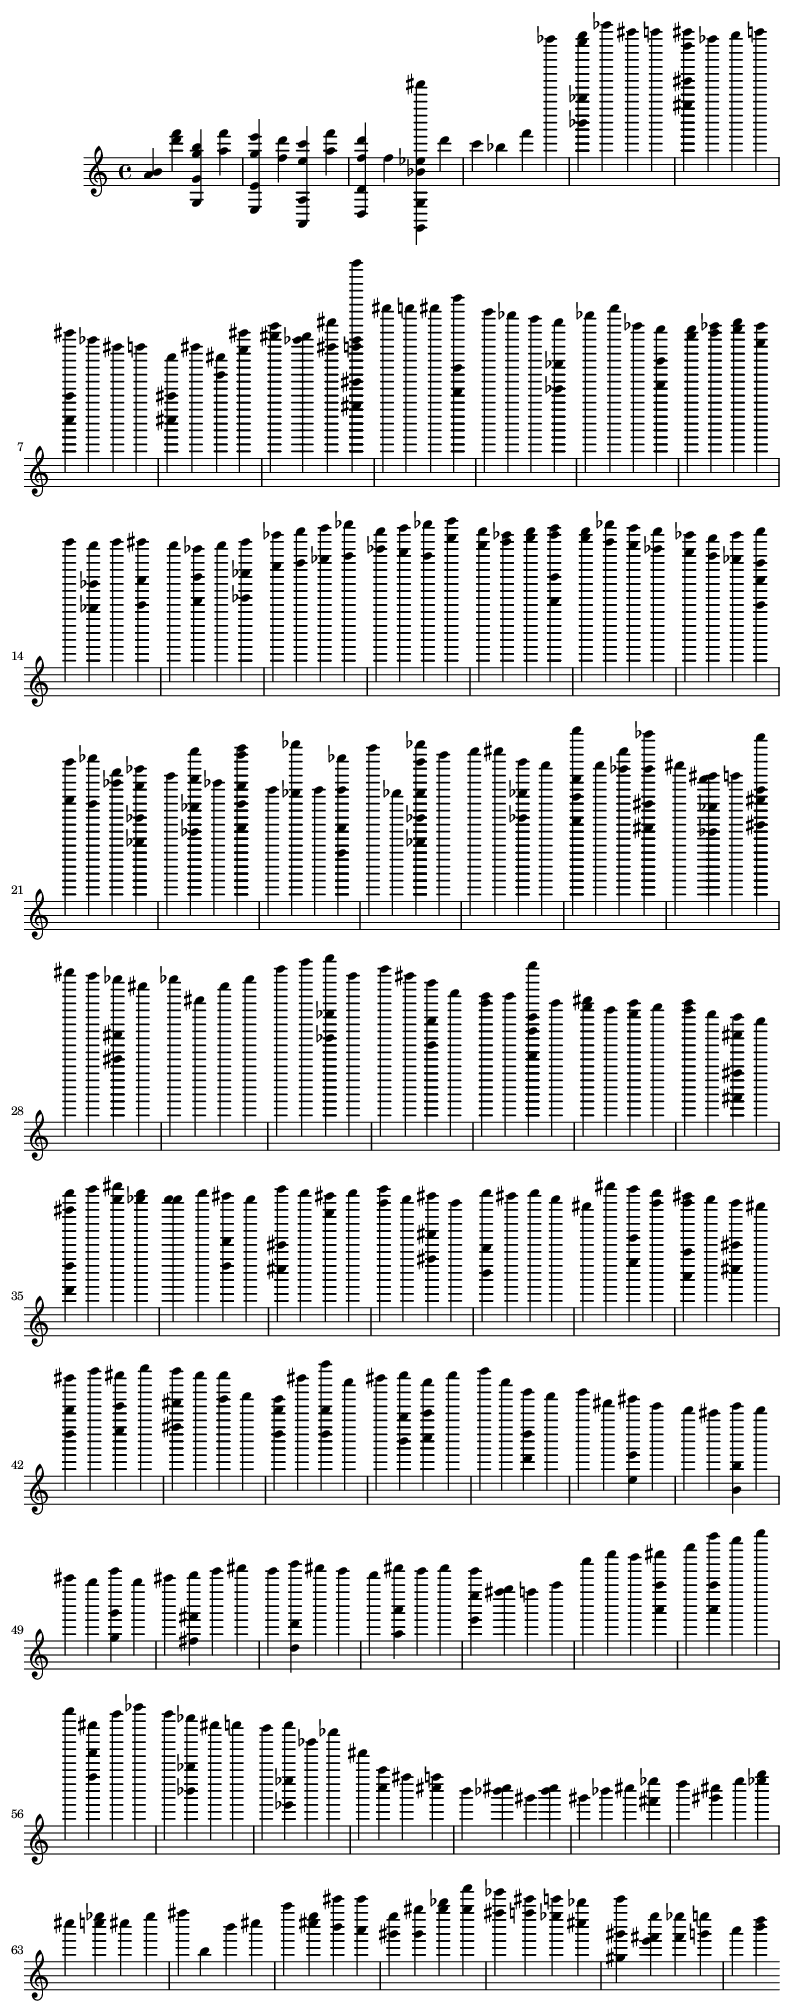

In [79]:
Image(filename=st1.write('lily.png'))

## to midi file

In [ ]:
st1.write('midi', fp ='tmp/rnn_generated_1229.midi' )

In [ ]:
import pygame
freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)
pygame.mixer.music.set_volume(0.8)

In [ ]:
sp = midi.realtime.StreamPlayer(st1)
sp.play()

In [ ]:
st1.show('midi')

## sandbox

In [ ]:
st2 = stream.Stream()

In [ ]:
st2.insert(0 , chord.Chord([note.Note('C5') , note.Note('D5'), note.Note('F5') ,note.Note('F6'),note.Note('A7')]))

In [ ]:
st2.insert(0 , chord.Chord([note.Note('C5')])) 

In [ ]:
run_notes

In [ ]:
st2.insert(0 , chord.Chord(run_notes))

In [ ]:
Image(filename=st2.write('lily.png'))

# 比較用にlinear modelを用いてgenerate

In [ ]:
df_stage.columns

In [ ]:
sequence_gen = [800,200,0]

In [ ]:
N_gen = 100

noise_strength = 0.1 #1にするとmseの誤差項の大きさをそのまま使う

In [ ]:
for i in range(N_gen):
    df_gen = pd.DataFrame({'dcent_lag1':[sequence_gen[-1]] , 'dcent_lag2':[sequence_gen[-2]] , 'dcent_lag3':[sequence_gen[-3]]})
    sequence_gen.append(int(res.predict(df_gen + noise_strength * np.sqrt(res.mse_resid) * np.random.normal()) / 100) * 100)

In [ ]:
sequence_gen[0:20]

In [ ]:
shift_cumsum_gen = np.array(sequence_gen).cumsum() 

In [ ]:
st1=stream.Stream()

In [ ]:
dt = 0.5
base_note = note.Note("C5")

In [ ]:
for i in range(shift_cumsum_gen.shape[0]):
    run_shift = int(shift_cumsum_gen[i] / 100)
    run_dt = int()
    if run_shift == 0:
        run_note = base_note
    else:                                      
        run_note = base_note.transpose(interval.ChromaticInterval(run_shift))
    st1.insert(0.5 * i , run_note)

In [ ]:
run_shift == 0

In [ ]:
from IPython.display import Image

In [ ]:
Image(filename=st1.write('lily.png'))

## to midi file

In [ ]:
st1.write('midi', fp ='tmp/tmp.midi' )

## sandbox

In [ ]:
tmp = note.Note("D5")

In [ ]:
tmp.transpose(interval.GenericInterval(1))

In [ ]:
x = torch.cat([x0, x1] , dim = 0)

In [ ]:
x2 = model.forward(x)

In [ ]:
x2.shape

In [ ]:
x2[-2:-1].shape

In [ ]:
x = torch.cat([x, x2[-2:-1]] , dim = 0)

# my own try and error　（この節のプロセスは必要ない）

# Before starting the note...
Useful tips for jupyter notebook:

https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

In [ ]:
#http://d.hatena.ne.jp/naraba/20121201/p1
#http://web.mit.edu/music21/doc/usersGuide/usersGuide_01_installing.html

from music21 import *
#environment.set('musicxmlPath' , r"C:\Program Files (x86)\Finale NotePad 2012\Finale NotePad.exe")
#configure.run()
#environment.keys()
#environment.get('musicxmlPath')

楽譜を表示するためのおまじない

参考URL:https://groups.google.com/forum/#!topic/music21list/FmU6HeNm7AM


In [ ]:
us = environment.UserSettings() #不必要

#us.create()
us['musicxmlPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'
us['musescoreDirectPNGPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'

# install musescore in linux (apt-getでインストールするのがポイント）

For all those who will struggle with displaying scores from music21 within Jupyter Notebook on Linux (e.g. Ubuntu), follow these steps:
https://stackoverflow.com/questions/49939275/python-music21-library-create-png-from-stream/49945456#49945456

MuseScoreのバージョンが2から3にあがっていたので、初期設定のままではうごきませんでした。
https://qiita.com/nofrmm/items/c3662555b145f6b42d92

#us.create()
us['musicxmlPath'] = r'/snap/bin/musescore'
us['musescoreDirectPNGPath'] = r'/snap/bin/musescore'

In [ ]:
environment.set("musescoreDirectPNGPath", "/usr/bin/musescore")
#environment.set("musicxmlPath", "/snap/bin/musescore")

#us.create()
us['musicxmlPath'] = r'/snap/bin/musescore.mscore'
us['musescoreDirectPNGPath'] = r'/snap/bin/musescore.mscore'

In [ ]:
%load_ext music21.ipython21　#不必要